### Importing Relevant libraries

In [1]:
## Importing the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier,StackingClassifier, VotingClassifier 
from matplotlib import colors
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import KFold
from itertools import product
from collections import OrderedDict
#!pip install explainerdashboard
from explainerdashboard import ClassifierExplainer, ExplainerDashboard,InlineExplainer


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


## Reading the Data & Cleaning
#### Reading both Cross-Sectional and Longitudinal Data

In [2]:
## Reading the data
cross = pd.read_csv("C:/Users/priya/Desktop/DS2 Project/oasis_cross-sectional.csv")
long = pd.read_csv("C:/Users/priya/Desktop/DS2 Project/oasis_longitudinal.csv",encoding = 'unicode_escape')

## Printing the sahpe of the datasets
print(cross.shape)
print(long.shape)

(436, 12)
(373, 15)


#### Dropping unnecessary columns & Concatenating both datasets

In [3]:
## Since majority of Delay Data is null we drop the feature
## Also drop the ID and unnecessary columns
cross.drop(columns=['Delay', 'Hand'], inplace=True)
long.drop(columns=['Subject ID','Visit','MR Delay','Group', 'Hand'], inplace=True)

## Renaming the column names
cross.rename(columns={'M_F':'M/F','EDUC':'Educ'}, inplace=True)
long.rename(columns={'EDUC':'Educ', 'MRI ID':'ID'}, inplace=True)
print(cross.info())
print(long.info())

## Concating the tables
df=pd.concat([cross,long])
df.reset_index(inplace=True)
df.set_index('ID',inplace=True)
df.drop(columns=['index'], inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Age     436 non-null    int64  
 3   Educ    235 non-null    float64
 4   SES     216 non-null    float64
 5   MMSE    235 non-null    float64
 6   CDR     235 non-null    float64
 7   eTIV    436 non-null    int64  
 8   nWBV    436 non-null    float64
 9   ASF     436 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 34.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      373 non-null    object 
 1   M/F     373 non-null    object 
 2   Age     373 non-null    int64  
 3   Educ    373 non-null    int64  
 4   SES     354 non-null    float64
 5   MMSE    371 no

#### Missing Value Treatment

In [4]:
## Checking combined dataset for any missing values
Missing_Value=df.isnull().sum()
Missing_Value_Percent= round(df.isna().sum()*100/len(df),1)
Missing_Value_df=pd.concat([Missing_Value,Missing_Value_Percent],axis=1)
Missing_Value_df.rename(columns={0 : 'Missing Values', 1 : '% of Missing Values'})

,Missing Values,% of Missing Values
M/F,0,0.0
Age,0,0.0
Educ,201,24.8
SES,239,29.5
MMSE,203,25.1
CDR,201,24.8
eTIV,0,0.0
nWBV,0,0.0
ASF,0,0.0


In [5]:
## Removing the dependent Variable with missing values
df.dropna(subset=['CDR'], inplace=True)
print(df.shape)

(608, 9)


In [6]:
## Checking for missing values after dropping missing CDR values
Missing_Value=df.isnull().sum()
Missing_Value_Percent= round(df.isna().sum()*100/len(df),1)
Missing_Value_df=pd.concat([Missing_Value,Missing_Value_Percent],axis=1)
Missing_Value_df.rename(columns={0 : 'Missing Values', 1 : '% of Missing Values'})

,Missing Values,% of Missing Values
M/F,0,0.0
Age,0,0.0
Educ,0,0.0
SES,38,6.2
MMSE,2,0.3
CDR,0,0.0
eTIV,0,0.0
nWBV,0,0.0
ASF,0,0.0


In [7]:
## Imputing missng values with SimpleImputer
imputer=SimpleImputer(missing_values=np.nan)
df[['SES','MMSE']]= imputer.fit_transform(df[['SES','MMSE']])

## Checking if any null values exist after imputation
Missing_Value=df.isnull().sum()
Missing_Value_Percent= round(df.isna().sum()*100/len(df),1)
Missing_Value_df=pd.concat([Missing_Value,Missing_Value_Percent],axis=1)
Missing_Value_df.rename(columns={0 : 'Missing Values', 1 : '% of Missing Values'})

,Missing Values,% of Missing Values
M/F,0,0.0
Age,0,0.0
Educ,0,0.0
SES,0,0.0
MMSE,0,0.0
CDR,0,0.0
eTIV,0,0.0
nWBV,0,0.0
ASF,0,0.0


## Exploratory Data Analysis

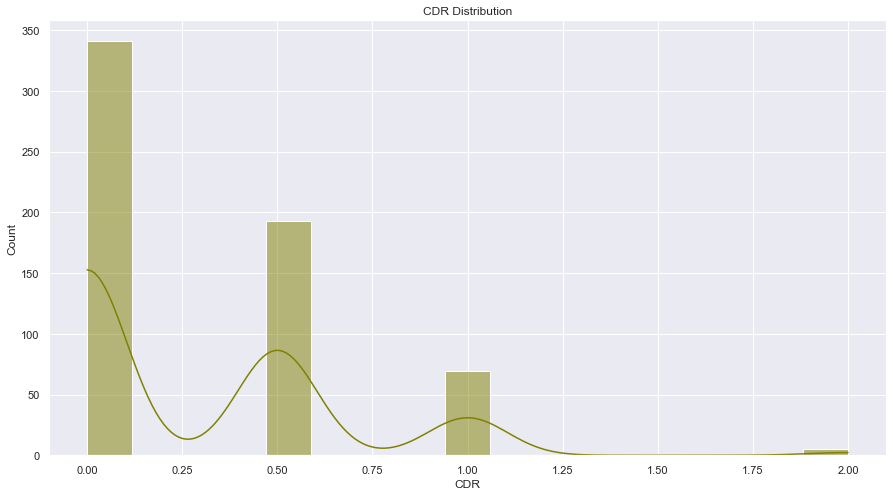

In [8]:
# EDA
df_final=df.copy()
#df_final.reset_index(inplace=True)
#df_final.drop(columns=['index'], inplace=True)
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=df_final, x="CDR", color='olive', kde=True).set(title="CDR Distribution")
plt.show()

In [9]:
## Creating the target variable for Demented

## Since the values of CDR Distribution (0.5=Very Mild Dementia, 1=Mild Dementia, 2=Moderate Dementia) specially for 1 and 2 are small
## Combine 0.5, 1 and 2 as demented class while 0 as Non-demented class
df_final['CDR'] = df_final['CDR'].map({0.5: 'Demented', 1.0: 'Demented', 2.0: 'Demented', 0: 'Non-Demented'})
df_final['SES'] = df_final['SES'].astype('category')
df_final['Educ'] = df_final['Educ'].astype('int')
df_final.head(100)

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
ID,,,,,,,,,
OAS1_0001_MR1,F,74,2,3.0,29.0,Non-Demented,1344,0.743,1.306
OAS1_0002_MR1,F,55,4,1.0,29.0,Non-Demented,1147,0.810,1.531
OAS1_0003_MR1,F,73,4,3.0,27.0,Demented,1454,0.708,1.207
OAS1_0010_MR1,M,74,5,2.0,30.0,Non-Demented,1636,0.689,1.073
OAS1_0011_MR1,F,52,3,2.0,30.0,Non-Demented,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...
OAS1_0197_MR1,F,89,3,3.0,29.0,Non-Demented,1154,0.747,1.521
OAS1_0199_MR1,M,69,5,1.0,30.0,Non-Demented,1601,0.784,1.096
OAS1_0200_MR1,F,60,2,4.0,30.0,Non-Demented,1366,0.807,1.285


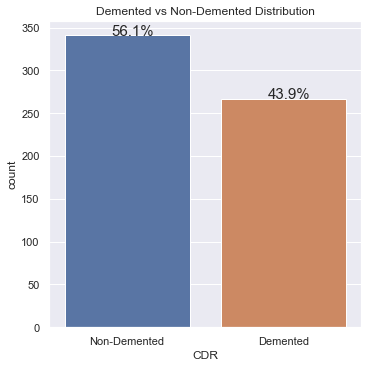

In [10]:
## Define function to add % to the graphs
def plt_percentage(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.10
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 15)
        
sns.set(style="darkgrid")
fig, axs = plt.subplots(figsize=(5, 5), constrained_layout=True)
sns.countplot(data=df_final, x="CDR").set(title="Demented vs Non-Demented Distribution")
plt_percentage(axs,df_final.CDR)
plt.show()

In [11]:
# sns.set(style="darkgrid")
# fig, axs = plt.subplots(2, 4, figsize=(20, 5), constrained_layout=True)

# sns.countplot(data=df_final, x="Educ", hue='CDR',ax=axs[0,0]).set(title="Education Distribution")
# sns.countplot(data=df_final, x="M/F", hue='CDR',ax=axs[0,1]).set(title="Gender Distribution")
# sns.histplot(data=df_final, x="Age", kde=True, color="skyblue", hue='CDR',binwidth=1,ax=axs[0,2]).set(title="Age Distribution")
# sns.histplot(data=df_final, x="SES", kde=True,hue='CDR', color="skyblue", ax=axs[0,3]).set(title="Socio Economic Status Distribution")
# sns.histplot(data=df_final, x="MMSE", kde=True,hue='CDR', color="skyblue", ax=axs[1,0]).set(title="Min Mental State Examination")
# sns.histplot(data=df_final, x="eTIV", kde=True, hue='CDR', ax=axs[1,1]).set(title="Estimated Total Intracranial Volume Distribution")
# sns.histplot(data=df_final, x="nWBV", kde=True, hue='CDR',color="skyblue", ax=axs[1,2]).set(title="Normalize Whole Brain Volume Distribution")
# sns.histplot(data=df_final, x="ASF", kde=True, hue='CDR',color="skyblue", ax=axs[1,3]).set(title="Atlas Scaling Factor Distribution")
# plt.show()

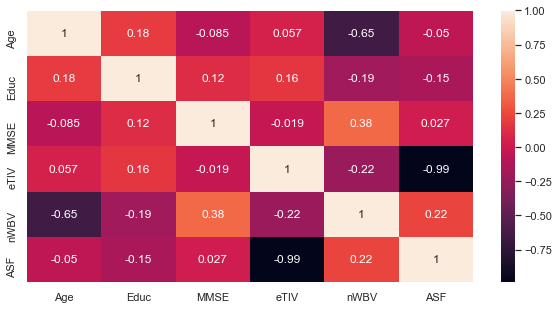

In [12]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.heatmap(df_final.corr(), annot=True)
plt.show()

## Model
### Train Test Split

In [13]:
## Train/Test Split
random_state=99

df_final_model=df_final.copy()
df_final_model['CDR'] = df_final_model['CDR'].map({'Demented': 1, 'Non-Demented': 0})
X=df_final_model.drop(['CDR'],axis=1)
y=df_final_model['CDR']
X_train, X_val, y_train,y_val = train_test_split(X,y,train_size=0.8, random_state=random_state)
print('X Train Shape:',X_train.shape, 'Y Train Shape:',y_train.shape, '\nX Validation Shape:',X_val.shape, 'Y Validation Shape:',y_val.shape)

X Train Shape: (486, 8) Y Train Shape: (486,) 
X Validation Shape: (122, 8) Y Validation Shape: (122,)


### Base Model - Logistic Regression

In [14]:
## Building Pipeline for Base Model
numerical_features= ['Age', 'Educ', 'MMSE','eTIV','nWBV', 'ASF']
categorical_features = ['M/F', 'SES']
numerical_transform = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transform = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
preprocessor = ColumnTransformer(transformers=[('numerical', numerical_transform, numerical_features),('categorical', categorical_transform, categorical_features)])

## Logistic Regression pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),('lr', LogisticRegression(random_state=random_state))])

# Fit the model & Predict on the Train set0
pipeline_lr.fit(X_train,y_train)
y_pred_lr_train=pipeline_lr.predict(X_train)

## Predict on the validation set
y_pred_lr=pipeline_lr.predict(X_val)

## Overall Accuracy
test_accuracy_lr_best_c=round(accuracy_score(y_val, y_pred_lr)*100,2)
print('Training accuracy: %.2f' % round(accuracy_score(y_train, y_pred_lr_train)*100,2)+'%')
print('Test Accuracy: %.2f' % round(accuracy_score(y_val, y_pred_lr)*100,2)+'%')

Training accuracy: 82.10%
Test Accuracy: 86.07%


Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.95      0.87        62
           1       0.94      0.77      0.84        60

    accuracy                           0.86       122
   macro avg       0.87      0.86      0.86       122
weighted avg       0.87      0.86      0.86       122



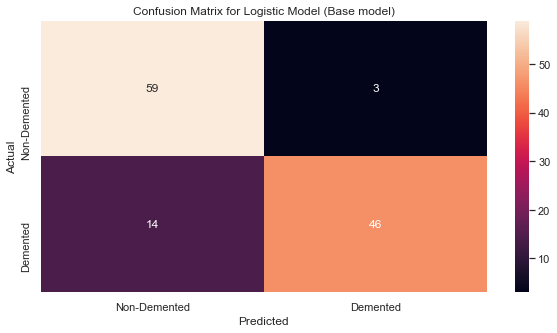

In [15]:
# Plot the confusion matrix
print('Classification Report \n',classification_report(y_val, y_pred_lr))
ax=sns.heatmap(confusion_matrix(y_val, y_pred_lr),annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix for Logistic Model (Base model)")
ax.xaxis.set_ticklabels(['Non-Demented','Demented'])
ax.yaxis.set_ticklabels(['Non-Demented','Demented'])
plt.show()

### Experimenting with Different Bagging & Boosting Models with hyperparameters

In [16]:
## Creating multiple models
## Logistic Regression
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),('lr', LogisticRegression(random_state=random_state))])
## Decision Tree
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),('dt', DecisionTreeClassifier(random_state=random_state))])
## Bagging Classifier
pipeline_bc = Pipeline(steps=[('preprocessor', preprocessor),('bc', BaggingClassifier(random_state=random_state))])
## Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),('rf', RandomForestClassifier(random_state=random_state))])
## Adaboost
pipeline_ada = Pipeline(steps=[('preprocessor', preprocessor),('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=random_state))])
## GradientBoosting Classifier
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),('gb', GradientBoostingClassifier(random_state=random_state))])

## Grid Search Parameters
criterion = ['gini', 'entropy']
max_depth = range(2,20)
min_samples_split=range(2,20)
n_estimators = [100,200,300,500]
max_features = range(2, 10)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.0002,0.002, 0.02, 0.2,1.0,2.0]


grid_params_lr = [{'lr__penalty': ['l1', 'l2'],'lr__C': np.logspace(0,20,1),'lr__solver': ['liblinear']}] 
grid_params_dt = [{'dt__criterion': criterion,'dt__max_depth': max_depth,'dt__min_samples_split': min_samples_split}] 
grid_params_bc = [{'bc__n_estimators': range(10,100,10)}]
grid_params_rf = [{'rf__n_estimators':n_estimators,'rf__max_features': max_features,'rf__max_depth': max_depth}]
grid_params_ada = [{'ada__n_estimators': n_estimators, 'ada__learning_rate': learning_rate}]
grid_params_gb = [{'gb__n_estimators': n_estimators, 'gb__learning_rate': learning_rate}]

## Create grid searches with 10 Fold Cross-validation
gs_lr = GridSearchCV(estimator=pipeline_lr,param_grid=grid_params_lr,scoring='accuracy',cv=10)
gs_dt = GridSearchCV(estimator=pipeline_dt,param_grid=grid_params_dt,scoring='accuracy',cv=10)
gs_bc = GridSearchCV(estimator=pipeline_bc,param_grid=grid_params_bc,scoring='accuracy',cv=10)
gs_rf = GridSearchCV(estimator=pipeline_rf,param_grid=grid_params_rf,scoring='accuracy',cv=10)
gs_ada= GridSearchCV(estimator=pipeline_ada,param_grid=grid_params_ada,scoring='accuracy',cv=10)
gs_gb = GridSearchCV(estimator=pipeline_gb,param_grid=grid_params_gb,scoring='accuracy',cv=10)

# List of pipelines
grids = [gs_lr,gs_dt,gs_bc,gs_rf, gs_ada, gs_gb]

# Dictionary of Models
grid_dict = {0: 'Logistic Regression with Hyperparameter_tuning', 1: 'Decision Tree', 
             2: 'Bagging Classifier' ,3: 'Random Forest', 4: 'Adaboost', 5: 'Gradient Boosting'}


# Fit the grid search for each model
print('Fitting models on hyperparametrs....')
for i, model in enumerate(grids):
    print('\nModel: %s'% grid_dict[i])
    # Fit grid search
    model.fit(X_train, y_train)
    # Best parameters
    print('Best params: %s' % model.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.2f' % model.best_score_)
    # Predict on test data with best params
    y_pred = model.predict(X_val)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.2f ' % accuracy_score(y_val, y_pred))

Fitting models on hyperparametrs....

Model: Logistic Regression with Hyperparameter_tuning
Best params: {'lr__C': 1.0, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best training accuracy: 0.82
Test set accuracy score for best params: 0.89 

Model: Decision Tree
Best params: {'dt__criterion': 'gini', 'dt__max_depth': 8, 'dt__min_samples_split': 2}
Best training accuracy: 0.85
Test set accuracy score for best params: 0.85 

Model: Bagging Classifier
Best params: {'bc__n_estimators': 60}
Best training accuracy: 0.86
Test set accuracy score for best params: 0.89 

Model: Random Forest
Best params: {'rf__max_depth': 17, 'rf__max_features': 2, 'rf__n_estimators': 300}
Best training accuracy: 0.89
Test set accuracy score for best params: 0.92 

Model: Adaboost
Best params: {'ada__learning_rate': 0.0001, 'ada__n_estimators': 100}
Best training accuracy: 0.84
Test set accuracy score for best params: 0.82 

Model: Gradient Boosting
Best params: {'gb__learning_rate': 1.0, 'gb__n_estimators': 

### Further Tuning the Best Model - Random Forest

In [17]:
pipeline_rf_final = Pipeline(steps=[('preprocessor', preprocessor),('rf', RandomForestClassifier(random_state=random_state))])
grid_params_rf_final = [{'rf__n_estimators':[300],'rf__max_features': [2],'rf__max_depth': [20]}]
gs_rf_final = GridSearchCV(estimator=pipeline_rf_final,param_grid=grid_params_rf_final,scoring='accuracy')

model_rf_final=gs_rf_final.fit(X_train,y_train)
y_pred_rf_train=model_rf_final.predict(X_train)

## Predict on the validation set
y_pred_rf=model_rf_final.predict(X_val)

## Overall Accuracy
test_accuracy_rf_best_c=round(accuracy_score(y_val, y_pred_rf)*100,2)
print('Training accuracy: %.2f' % round(accuracy_score(y_train, y_pred_rf_train)*100,2)+'%')
print('Test Accuracy: %.2f' % round(accuracy_score(y_val, y_pred_rf)*100,2)+'%')

Training accuracy: 100.00%
Test Accuracy: 91.80%


Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92        62
           1       0.95      0.88      0.91        60

    accuracy                           0.92       122
   macro avg       0.92      0.92      0.92       122
weighted avg       0.92      0.92      0.92       122



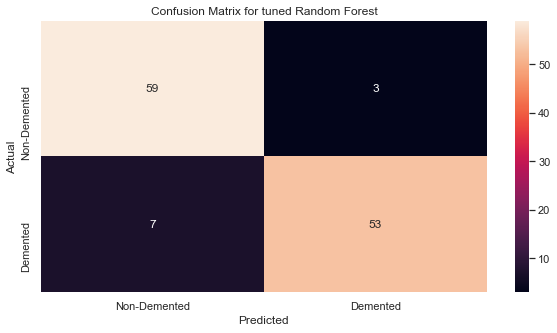

In [18]:
# Plot the confusion matrix
print('Classification Report \n',classification_report(y_val, y_pred_rf))
ax=sns.heatmap(confusion_matrix(y_val, y_pred_rf),annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix for tuned Random Forest")
ax.xaxis.set_ticklabels(['Non-Demented','Demented'])
ax.yaxis.set_ticklabels(['Non-Demented','Demented'])
plt.show()

## Building Dashboard for Train Data for Transparency & Interpretability

In [19]:
feature_descriptions = {
    "M/F": "Gender(M if Male, F if Female)",
    "Age": "Age in years",
    "Educ": "Years of Education",
    "SES": "SocioEconomic Status",
    "MMSE": "Mini Mental State Examination", 
    "eTIV": "Estimated Total Intracranial Volume",
    "nWBV": "Normalize Whole Brain Volume",
    "ASF": "Atlas Scaling Factor"
}

explainer1 = ClassifierExplainer(model_rf_final, X_train, y_train,
                               labels=['Non Demented', 'Demented'],
                               index_name = "Subjects",
                               target = "Demented", descriptions=feature_descriptions)

ExplainerDashboard(explainer1,title="Alzheimer Explainer - Train Dataset",mode='external',shap='tree',importances=True,
                    model_summary=True,
                    contributions=True,
                    whatif=True,
                    shap_dependence=True,
                    shap_interaction=True,
                    decision_trees=False,simple=True).run()

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Note: for ClassifierExplainer shap='kernel' defaults to model_output='probability
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Calculating shap values...


100%|██████████| 486/486 [05:00<00:00,  1.62it/s]

Generating layout...
Calculating confusion matrices...
Calculating prediction probabilities...


Calculating roc auc curves...
Calculating dependencies...
Calculating predictions...
Calculating pred_percentiles...
Calculating metrics...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.8:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on http://127.0.0.1:8050/


## Building Dashboard for Test Data for Transparency & Interpretability

In [20]:
feature_descriptions = {
    "M/F": "Gender(M if Male, F if Female)",
    "Age": "Age in years",
    "Educ": "Years of Education",
    "SES": "SocioEconomic Status",
    "MMSE": "Mini Mental State Examination", 
    "eTIV": "Estimated Total Intracranial Volume",
    "nWBV": "Normalize Whole Brain Volume",
    "ASF": "Atlas Scaling Factor"
}

explainer2 = ClassifierExplainer(model_rf_final, X_val, y_val,
                               labels=['Non Demented', 'Demented'],
                               index_name = "Subjects",
                               target = "Demented", descriptions=feature_descriptions)

ExplainerDashboard(explainer2,title="Alzheimer Explainer- Test Dataset",mode='external',shap='tree',importances=True,
                    model_summary=True,
                    contributions=True,
                    whatif=True,
                    shap_dependence=True,
                    shap_interaction=True,
                    decision_trees=True,simple=True).run()



Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Note: for ClassifierExplainer shap='kernel' defaults to model_output='probability
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Calculating shap values...


100%|██████████| 122/122 [01:19<00:00,  1.53it/s]

Generating layout...
Calculating confusion matrices...
Calculating prediction probabilities...


Calculating roc auc curves...
Calculating dependencies...
Calculating predictions...
Calculating pred_percentiles...
Calculating metrics...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.8:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on http://127.0.0.1:8050/
